In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

In [2]:
def load_and_preprocess_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    lab = rgb2lab(img).astype("float32")
    l = lab[:, :, 0] / 100.0
    l_tensor = torch.tensor(l).unsqueeze(0).unsqueeze(0)
    return img, l_tensor

In [3]:
encoder_layers = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
)

In [4]:
vgg = models.vgg16(pretrained=True).features[:23]
for param in vgg.parameters():
    param.requires_grad = False

global_pool = nn.AdaptiveAvgPool2d((1, 1))
fusion_fc = nn.Linear(512, 256 * 56 * 56)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 60.4MB/s]


In [5]:
decoder_layers = nn.Sequential(
    nn.Conv2d(256, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(128, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(64, 2, kernel_size=3, padding=1),
    nn.Tanh()
)

In [11]:

def colorize_image(l_tensor):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    l_tensor = l_tensor.to(device).float()

    encoder = encoder_layers.to(device).eval()
    decoder = decoder_layers.to(device).eval()
    vgg_model = vgg.to(device).eval()
    fc = fusion_fc.to(device).eval()

    with torch.no_grad():
        enc_out = encoder(l_tensor)


        vgg_input = l_tensor.repeat(1, 3, 1, 1)
        vgg_feat = vgg_model(vgg_input)
        global_feat = global_pool(vgg_feat).view(1, -1)

        fused = fc(global_feat).view(1, 256, 56, 56)

        fusion_out = enc_out + fused

        ab_output = decoder(fusion_out)

    return ab_output.cpu()

In [7]:
def display_original_and_colorized(original_rgb, l_tensor, ab_output):
    l = l_tensor.squeeze().numpy() * 100.0
    ab = ab_output.squeeze().detach().numpy() * 128.0
    ab = np.transpose(ab, (1, 2, 0))

    lab = np.zeros((224, 224, 3))
    lab[:, :, 0] = l
    lab[:, :, 1:] = ab
    colorized_rgb = lab2rgb(lab)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_rgb)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(colorized_rgb)
    plt.title("Colorized Output")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

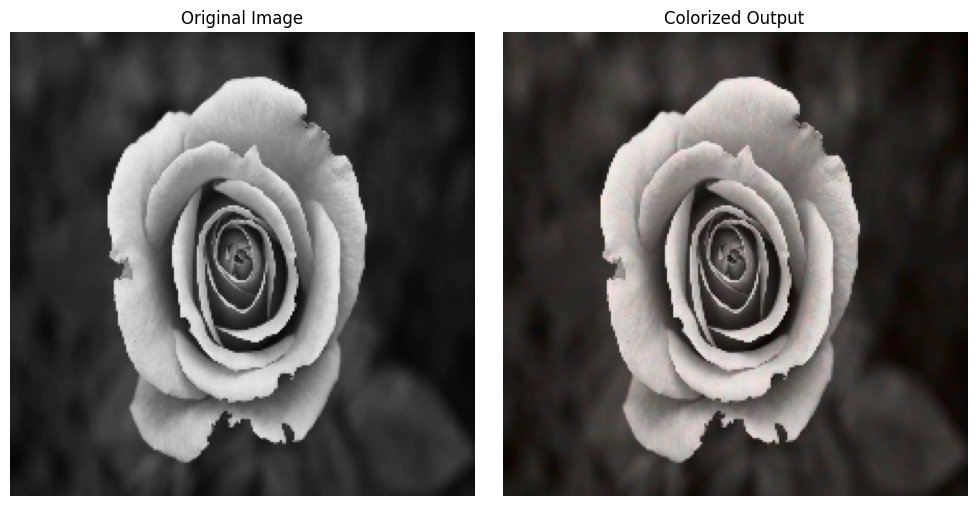

In [12]:
image_path = "bw1.jpg"
original_rgb, l_tensor = load_and_preprocess_image(image_path)
ab_output = colorize_image(l_tensor)
display_original_and_colorized(original_rgb, l_tensor, ab_output)